# Forecasting using machine learning
Using https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting/data

In [119]:
%matplotlib inline
import numpy as np
import pandas as pd
from itertools import count
from collections import OrderedDict
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import style
style.use('fivethirtyeight')

In [97]:
df = pd.read_csv('train.csv')

# Convert object to datetime
df['Date'] = pd.to_datetime(df['Date'])

In [7]:
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [8]:
# One-hot-encode "Store" and "Dept"
df = pd.get_dummies(df, columns=['Store', 'Dept'])

In [9]:
df.head()

,Date,Weekly_Sales,IsHoliday,Store_1,Store_2,Store_3,Store_4,Store_5,Store_6,Store_7,...,Dept_90,Dept_91,Dept_92,Dept_93,Dept_94,Dept_95,Dept_96,Dept_97,Dept_98,Dept_99
0,2010-02-05,24924.50,False,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2010-02-12,46039.49,True,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2010-02-19,41595.55,False,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2010-02-26,19403.54,False,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2010-03-05,21827.90,False,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
# Extract date features
df['Date_dayofweek'] = df['Date'].dt.dayofweek
df['Date_month'] = df['Date'].dt.month
df['Date_year'] = df['Date'].dt.year
df['Date_day'] = df['Date'].dt.day

In [11]:
# Extract time-lag features for 1 day, 2 day, 3 day, 5 day, 1 week, 2 week, and a month ago
for days_to_lag in [1, 2, 3, 5, 7, 14, 30]:
    df['Weekly_sales_lag_{}'.format(days_to_lag)] = df.Weekly_Sales.shift(days_to_lag)

In [12]:
df.head()

,Date,Weekly_Sales,IsHoliday,Store_1,Store_2,Store_3,Store_4,Store_5,Store_6,Store_7,...,Date_month,Date_year,Date_day,Weekly_sales_lag_1,Weekly_sales_lag_2,Weekly_sales_lag_3,Weekly_sales_lag_5,Weekly_sales_lag_7,Weekly_sales_lag_14,Weekly_sales_lag_30
0,2010-02-05,24924.50,False,1,0,0,0,0,0,0,...,2,2010,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2010-02-12,46039.49,True,1,0,0,0,0,0,0,...,2,2010,12,24924.50,NaN,NaN,NaN,NaN,NaN,NaN
2,2010-02-19,41595.55,False,1,0,0,0,0,0,0,...,2,2010,19,46039.49,24924.50,NaN,NaN,NaN,NaN,NaN
3,2010-02-26,19403.54,False,1,0,0,0,0,0,0,...,2,2010,26,41595.55,46039.49,24924.50,NaN,NaN,NaN,NaN
4,2010-03-05,21827.90,False,1,0,0,0,0,0,0,...,3,2010,5,19403.54,41595.55,46039.49,NaN,NaN,NaN,NaN


In [13]:
# Replace all NaN values with 0
df = df.fillna(0)

In [14]:
df.IsHoliday = df.IsHoliday.astype(int)

In [15]:
# Grab features and target
# Remove date from features because it's overly-unique
# Remove weekly_sales from features since it's the target and
# we don't have access to it at the time of prediction
x = df[df.columns.difference(['Date', 'Weekly_Sales'])]  
y = df.Weekly_Sales

In [16]:
x.head()

,Date_day,Date_dayofweek,Date_month,Date_year,Dept_1,Dept_10,Dept_11,Dept_12,Dept_13,Dept_14,...,Store_7,Store_8,Store_9,Weekly_sales_lag_1,Weekly_sales_lag_14,Weekly_sales_lag_2,Weekly_sales_lag_3,Weekly_sales_lag_30,Weekly_sales_lag_5,Weekly_sales_lag_7
0,5,4,2,2010,1,0,0,0,0,0,...,0,0,0,0.00,0.0,0.00,0.00,0.0,0.0,0.0
1,12,4,2,2010,1,0,0,0,0,0,...,0,0,0,24924.50,0.0,0.00,0.00,0.0,0.0,0.0
2,19,4,2,2010,1,0,0,0,0,0,...,0,0,0,46039.49,0.0,24924.50,0.00,0.0,0.0,0.0
3,26,4,2,2010,1,0,0,0,0,0,...,0,0,0,41595.55,0.0,46039.49,24924.50,0.0,0.0,0.0
4,5,4,3,2010,1,0,0,0,0,0,...,0,0,0,19403.54,0.0,41595.55,46039.49,0.0,0.0,0.0


In [17]:
y[:3]

0    24924.50
1    46039.49
2    41595.55
Name: Weekly_Sales, dtype: float64

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=1/3)

In [20]:
x_train.shape

(281046, 138)

In [21]:
x_test.shape

(140524, 138)

In [22]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [28]:
clf = LinearRegression()
clf.fit(x_train, y_train)

/Users/amir.ziai/anaconda/lib/python3.5/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [29]:
# Calculate R2
clf.score(x_test, y_test)

0.91383306146084409

In [30]:
%%time
clf = RandomForestRegressor(n_jobs=-1)  # use all cores
clf.fit(x_train, y_train)

CPU times: user 3min 8s, sys: 2.52 s, total: 3min 10s
Wall time: 47.8 s


In [58]:
# Better R2 with random forest
# You can probably do hyper-parameter grid/random search to improve
clf.score(x_test, y_test)

0.95018888743499019

In [23]:
def plot_feature_importance(clf, columns, threshold=0):
    """Plots feature importance for random forest and gradient boosting models
    :param threshold: features with importance values below this threshold are not displayed
    :return: None
    """
    model_object = clf

    if not hasattr(model_object, 'feature_importances_'):  # no feature importance
        raise ValueError("{} does not support feature importance".format(model_object.__class__))

    if hasattr(model_object, 'best_estimator_'):  # grid search object
        feature_importance_list = model_object.best_estimator_.feature_importances_
    else:
        feature_importance_list = model_object.feature_importances_
    feature_importance = {column_name: feature_importance for column_name, feature_importance in
                          zip(columns, feature_importance_list) if feature_importance >= threshold}
    pd.Series(feature_importance).sort_values(ascending=True).plot(kind='barh')
    plt.title('Feature importance')
    plt.show()

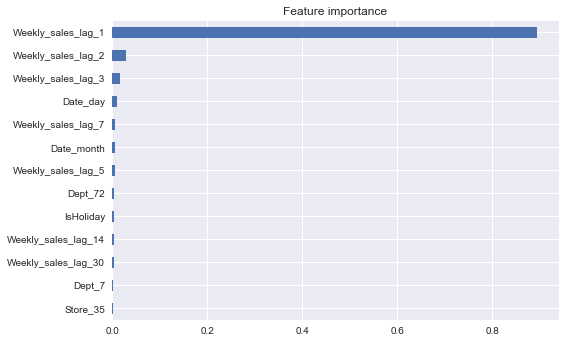

In [61]:
plot_feature_importance(clf, x_train.columns, 0.001)

In [31]:
# Other regression metrics
# http://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [32]:
# Mean absolute error
predicted = clf.predict(x_test)
mean_absolute_error(y_test, predicted)

1684.6299017463209

In [33]:
# MSE
mean_squared_error(y_test, predicted)

21523731.835704152

### Progress of feature engineering

In [65]:
def r2_based_on_columns(x_train, x_test, columns):
    clf = RandomForestRegressor(n_jobs=-1)  # use all cores
    clf.fit(x_train[columns], y_train)
    r2 = clf.score(x_test[columns], y_test)
    print('Test R2: {:.2f}, columns used: {}'.format(r2, columns))

In [78]:
r2_based_on_columns(x_train, x_test, ['Date_day', 'Date_dayofweek', 'Date_year'])
r2_based_on_columns(x_train, x_test, ['Weekly_sales_lag_2'])
r2_based_on_columns(x_train, x_test, ['Weekly_sales_lag_1'])
r2_based_on_columns(x_train, x_test, ['Weekly_sales_lag_1', 'Weekly_sales_lag_1', 'Date_day'])

Test R2: 0.00, columns used: ['Date_day', 'Date_dayofweek', 'Date_year']
Test R2: 0.83, columns used: ['Weekly_sales_lag_2']
Test R2: 0.87, columns used: ['Weekly_sales_lag_1']
Test R2: 0.90, columns used: ['Weekly_sales_lag_1', 'Weekly_sales_lag_1', 'Date_day']


### Applying in practice
How to predict from raw data
1. Raw data -> featurized data
2. Predict using the `predict` method on `clf`

### Outisde data

In [24]:
import pandas_datareader as pdr

In [25]:
# Get S&P index from Yahoo! Finance
s_and_p = pdr.get_data_yahoo('^GSPC')

In [26]:
s_and_p.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,1116.560059,1133.869995,1116.560059,1132.989990,1132.989990,3991400000
2010-01-05,1132.660034,1136.630005,1129.660034,1136.520020,1136.520020,2491020000
2010-01-06,1135.709961,1139.189941,1133.949951,1137.140015,1137.140015,4972660000
2010-01-07,1136.270020,1142.459961,1131.319946,1141.689941,1141.689941,5270680000
2010-01-08,1140.520020,1145.390015,1136.219971,1144.979980,1144.979980,4389590000


In [28]:
from datetime import datetime

In [47]:
def convert(x):
    return datetime(int(x['Date_year']), int(x['Date_month']), int(x['Date_day']))

In [ ]:
# Introduce these back, not efficient!
x_train['date'] = x_train.apply(convert, axis=1)
x_test['date'] = x_test.apply(convert, axis=1)

In [80]:
# Merging S&P data with our sales data
x_train_merged = pd.merge(x_train, s_and_p.reset_index('Date').rename(columns={'Date': 'date'}),
                          on='date', how='left').fillna(0)
x_test_merged = pd.merge(x_test, s_and_p.reset_index('Date').rename(columns={'Date': 'date'}),
                          on='date', how='left').fillna(0)

In [82]:
x_train.head()

,Date_day,Date_dayofweek,Date_month,Date_year,Dept_1,Dept_10,Dept_11,Dept_12,Dept_13,Dept_14,...,Store_8,Store_9,Weekly_sales_lag_1,Weekly_sales_lag_14,Weekly_sales_lag_2,Weekly_sales_lag_3,Weekly_sales_lag_30,Weekly_sales_lag_5,Weekly_sales_lag_7,date
19283,3,4,8,2012,0,0,0,0,0,0,...,0,0,94910.20,90916.58,97233.41,98850.80,102637.73,94527.06,100684.85,2012-08-03
284873,15,4,6,2012,0,0,0,0,0,0,...,0,0,5554.03,5351.12,5650.37,6002.57,4954.30,5633.92,5088.13,2012-06-15
291199,29,4,7,2011,0,0,0,0,0,0,...,0,0,104.13,51.76,22.96,18.27,125.42,76.48,124.19,2011-07-29
81841,17,4,6,2011,0,0,0,0,0,0,...,0,1,2383.59,2276.74,2392.98,2218.79,2814.48,2163.39,2357.07,2011-06-17
102836,10,4,6,2011,0,0,0,0,0,0,...,0,0,3044.03,4060.11,3164.73,3940.01,4149.13,3556.69,3590.84,2011-06-10


In [90]:
clf = RandomForestRegressor(n_jobs=-1)
columns = x_train_merged.columns.difference(['date'])
clf.fit(x_train_merged[columns], y_train)
clf.score(x_test_merged[columns], y_test)

0.96251421021848749

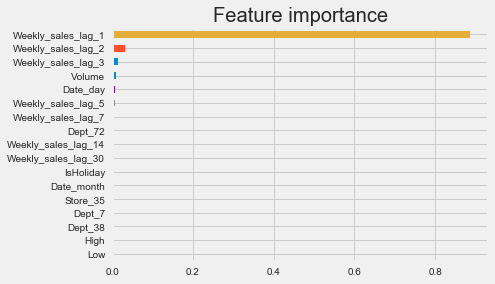

In [106]:
plot_feature_importance(clf, columns, 0.001)

Interestingly enough S&P 500 "volume" is in the list of the important features now.

### Anomaly detection

> Contextual anomalies: The abnormality is context specific. This type of anomaly is common in time-series data. Business use case: Spending $100 on food every day during the holiday season is normal, but may be odd otherwise.[1]

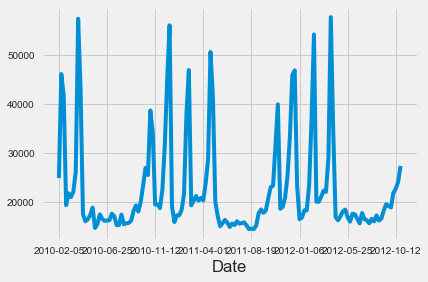

In [105]:
# Let's focus on department 1 of store 1
store1_dept1 = pd.read_csv('train.csv')[(df.Store == 1) & (df.Dept == 1)]
store1_dept1.set_index('Date')['Weekly_Sales'].plot()

In [131]:
# Taken from https://www.datascience.com/blog/python-anomaly-detection

def moving_average(data, window_size):
    """ Computes moving average using discrete linear convolution of two one dimensional sequences.
    Args:
    -----
            data (pandas.Series): independent variable
            window_size (int): rolling window size

    Returns:
    --------
            ndarray of linear convolution

    References:
    ------------
    [1] Wikipedia, "Convolution", http://en.wikipedia.org/wiki/Convolution.
    [2] API Reference: https://docs.scipy.org/doc/numpy/reference/generated/numpy.convolve.html

    """
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(data, window, 'same')


def explain_anomalies(y, window_size, sigma=1.0):
    """ Helps in exploring the anamolies using stationary standard deviation
    Args:
    -----
        y (pandas.Series): independent variable
        window_size (int): rolling window size
        sigma (int): value for standard deviation

    Returns:
    --------
        a dict (dict of 'standard_deviation': int, 'anomalies_dict': (index: value))
        containing information about the points indentified as anomalies

    """
    avg = moving_average(y, window_size).tolist()
    residual = y - avg
    # Calculate the variation in the distribution of the residual
    std = np.std(residual)
    return {'standard_deviation': round(std, 3),
            'anomalies_dict': OrderedDict([(index, y_i) for
                                                       index, y_i, avg_i in zip(count(), y, avg)
              if (y_i > avg_i + (sigma*std)) | (y_i < avg_i - (sigma*std))])}


def explain_anomalies_rolling_std(y, window_size, sigma=1.0):
    """ Helps in exploring the anamolies using rolling standard deviation
    Args:
    -----
        y (pandas.Series): independent variable
        window_size (int): rolling window size
        sigma (int): value for standard deviation

    Returns:
    --------
        a dict (dict of 'standard_deviation': int, 'anomalies_dict': (index: value))
        containing information about the points indentified as anomalies
    """
    avg = moving_average(y, window_size)
    avg_list = avg.tolist()
    residual = y - avg
    # Calculate the variation in the distribution of the residual
    testing_std = pd.rolling_std(residual, window_size)
    testing_std_as_df = pd.DataFrame(testing_std)
    rolling_std = testing_std_as_df.replace(np.nan,
                                  testing_std_as_df.ix[window_size - 1]).round(3).iloc[:,0].tolist()
    std = np.std(residual)
    return {'stationary standard_deviation': round(std, 3),
            'anomalies_dict': collections.OrderedDict([(index, y_i)
                                                       for index, y_i, avg_i, rs_i in izip(count(),
                                                                                           y, avg_list, rolling_std)
              if (y_i > avg_i + (sigma * rs_i)) | (y_i < avg_i - (sigma * rs_i))])}


# This function is repsonsible for displaying how the function performs on the given dataset.
def plot_results(x, y, window_size, sigma_value=1,
                 text_xlabel="X Axis", text_ylabel="Y Axis", applying_rolling_std=False):
    """ Helps in generating the plot and flagging the anamolies.
        Supports both moving and stationary standard deviation. Use the 'applying_rolling_std' to switch
        between the two.
    Args:
    -----
        x (pandas.Series): dependent variable
        y (pandas.Series): independent variable
        window_size (int): rolling window size
        sigma_value (int): value for standard deviation
        text_xlabel (str): label for annotating the X Axis
        text_ylabel (str): label for annotatin the Y Axis
        applying_rolling_std (boolean): True/False for using rolling vs stationary standard deviation
    """
    plt.figure(figsize=(15, 8))
    plt.plot(x, y, "k.")
    y_av = moving_average(y, window_size)
    plt.plot(x, y_av, color='green')
    plt.xlim(0, 143)
    plt.xlabel(text_xlabel)
    plt.ylabel(text_ylabel)

    # Query for the anomalies and plot the same
    events = {}
    if applying_rolling_std:
        events = explain_anomalies_rolling_std(y, window_size=window_size, sigma=sigma_value)
    else:
        events = explain_anomalies(y, window_size=window_size, sigma=sigma_value)

    x_anomaly = np.fromiter(events['anomalies_dict'].keys(), dtype=int, count=len(events['anomalies_dict']))
    y_anomaly = np.fromiter(events['anomalies_dict'].values(), dtype=float,
                                            count=len(events['anomalies_dict']))
    plt.plot(x_anomaly, y_anomaly, "r*", markersize=12)

    # add grid and lines and enable the plot
    plt.grid(True)
    plt.show()

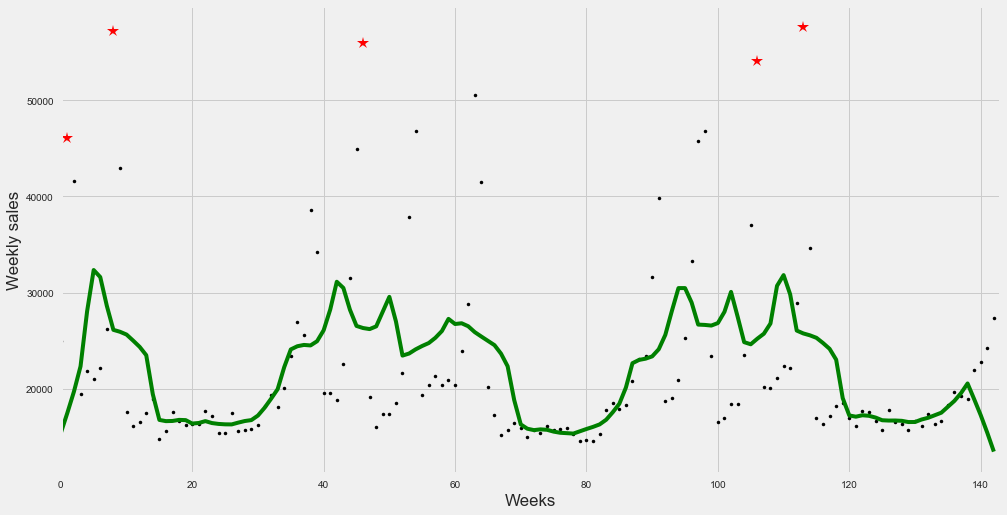

In [130]:
# plot the results
plot_results(store1_dept1.index, y=store1_dept1.Weekly_Sales,
             window_size=10, text_xlabel="Weeks", sigma_value=3,
             text_ylabel="Weekly sales")
events = explain_anomalies(y, window_size=5, sigma=3)

### TODO
1. Error analysis for the model
2. Use more outside data

### References
[1] https://www.datascience.com/blog/python-anomaly-detection